In [118]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from skimage.io import ImageCollection
from skimage.data import imread
from skimage.color import rgb2hsv, rgb2gray
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage.feature import (ORB, match_descriptors, corner_harris,
                             plot_matches)
from skimage.measure import ransac
from numpy.random import randint
%matplotlib inline

In [4]:
pano_imgs = ImageCollection('*.jpg')

img_feat = {}
num_imgs = len(img_col)
min_matches = 40
num_keypoints = 800

In [5]:
def compare(*images, **kwargs):
    """
    Function to display images side by side (from skimage example)

    Parameters
    ----------
    image0, image1, ....: ndarray
        Images to display
    labels: list
        Labels for the different images
    """
    f, ax = plt.subplots(1, len(images), **kwargs)
    ax = np.array(ax, ndmin=1)

    labels = kwargs.pop('labels', None)
    labels = [''] * len(images)
    for n, (image, label) in enumerate(zip(images, labels)):
        ax[n].imshow(image, interpolation='nearest', cmap=plt.gray())
        ax[n].set_title(label)
        #ax[n].axis('off')
    plt.tight_layout()

In [6]:
def get_best_matches(k1, k2, matches):
    src = k1[matches[:,0]][:,::-1]
    dst = k2[matches[:,1]][:,::-1]
    # if there are not enough matches, this fails
    model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                                   min_samples=20, residual_threshold=1,
                                   max_trials=40)

    return model_robust, inliers

def develop_metadata_mosaic():
    # set max pitch and roll angles as qulity
    pass

In [90]:
def hsv_imread(img_path):
    return rgb2hsv(imread(img_path))

def load_images(search_dir, ftype):
    search_path = os.path.join(search_dir, '*'+ftype)
    imgs = ImageCollection(search_path, conserve_memory=False,
                           load_func=hsv_imread)
    return imgs
img_col = load_images('../data/jpg/', 'jpg')[:50]

def plot_two_matches(img1, img2, k1, k2, matches):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.gray()
    #plot_matches(ax, img1, img2, k1, k2, matches)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].scatter(k1[:, 1], k1[:, 0],  facecolors='none', edgecolors='r')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].scatter(k2[:, 1], k2[:, 0], facecolors='none', edgecolors='r')
    plt.show()
    
    plt.show()
    
def plot_two_keypoints(img1, img2, k1, k2, s1=1, s2=1):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.gray()

    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].scatter(k1[:, 1], k1[:, 0], facecolors='none', edgecolors='r')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].scatter(k2[:, 1], k2[:, 0], facecolors='none', edgecolors='r')
    plt.show()

In [119]:
def find_mask(base_img, img, model_robust):
    output_shape, corner_min = find_output_shape(base_img, model_robust)
    #print("my output_shape", output_shape, corner_min)
    #print(model_robust.scale, model_robust.translation, model_robust.rotation)
    
    # This in-plane offset is the only necessary transformation for the base image
    offset = SimilarityTransform(translation= -corner_min)
    base_warped = warp(base_img, offset.inverse, order=3, 
                      output_shape = output_shape, cval=-1)
    
    # warp image corners to new position in mosaic
    transform = (model_robust + offset).inverse
    
    img_warped = warp(img, transform, order=3, 
                      output_shape=output_shape, cval=-1)
    
    base_mask = (base_warped != -1)
    base_warped[~base_mask] = 0

    img_mask = (img_warped != -1)
    img_warped[~img_mask] = 0
    
    
    # Add the three images together. This could create dtype overflows!
    # We know they are are floating point images after warping, so it's OK.
    merged = (base_warped + img_warped)

    # Track the overlap by adding the masks together
    overlap = (base_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
               img_mask)

    # Normalize through division by `overlap` - but ensure the minimum is 1
    norm = merged / np.maximum(overlap, 1)
    
    return norm
    

In [92]:
def detect_and_extract(detector, img):
    detector.detect_and_extract(img)
    keypoints = detector.keypoints
    descriptors = detector.descriptors
    return keypoints, descriptors

In [93]:
def find_output_shape(base_img, model_robust):
    r, c = base_img.shape[:2]
    print(r,c)
    corners = np.array([[0,0], 
                        [0,r],
                        [c,0],
                        [c,r]])
    warped_corners = model_robust(corners)
    all_corners = np.vstack((warped_corners, corners))
    # The overally output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    return output_shape, corner_min


In [135]:
def find_two_matches(base_img, img2, base_k, k2, base_d, d2):
    #matches = match_descriptors(d1, d2, max_distance=.2, cross_check=True)
    matches = match_descriptors(base_d, d2, cross_check=True)
    
    #   * src (image to be registered): pano2
    #   * dst (reference image): pano1, our middle frame registration target
    src = k2[matches[:,1]][:,::-1]
    dst = base_k[matches[:,0]][:,::-1]
    
   
    # if there are not enough matches, this fails
    #fig, ax = plt.subplots(1,1,figsize=(15,12))
    #plot_matches(ax, base_img, img2, base_k, k2, matches)
    if matches.shape[0] > 4:
        model_robust, inliers = ransac((src, dst), AffineTransform,
                                   min_samples=4, residual_threshold=1,
                                   max_trials=300)

        ransac_matches = matches[inliers]
        #print('matches', matches.shape)
        #print('ransac matches', ransac_matches.shape)
        
        #fig, ax = plt.subplots(1,1,figsize=(15,12))
        #plot_matches(ax, base_img, img2, base_k, k2, ransac_matches)

        return model_robust, ransac_matches
    else:
        return np.zeros((0, 2)), np.zeros((0, 2))

In [136]:
#t = (0,-150)
#t = (-150,-300)
t = (0, 200)
tform = SimilarityTransform(translation=t)


base_img = rgb2gray(pano_imgs[1][:,:,2])
#img2 = warp(base_img, tform)
img2 = rgb2gray(pano_imgs[2])


#k2, d2 = detect_and_extract(orb, img2)   

#find_two_matches(base_img, img2, base_k, k2, base_d, d2)

#matches12 = match_descriptors(base_d, d2, cross_check=True)
#print('match 12', matches12.shape)

img0 = rgb2gray(pano_imgs[0])
base_img = rgb2gray(pano_imgs[1])
img2 = rgb2gray(pano_imgs[2])



    

## Match descriptors between left/right images and the center
#matches10 = match_descriptors(base_d, d0, cross_check=True)

#matches12 = match_descriptors(base_d, d2, cross_check=True)

#model_robust10, ransac_matches10 = find_two_matches(base_img, img0, base_k, k0, base_d, d0)
#model_robust12, ransac_matches12 = find_two_matches(base_img, img2, base_k, k2, base_d, d2)

#nn0 = find_mask(base_img, img0, model_robust10)
#plt.show()
#nn2 = find_mask(base_img, img2, model_robust12)
#plt.show()
#fig, ax = plt.subplots(1,1,figsize=(15,12))
#plot_matches(ax, base_img, img2, base_k, k2, ransac_matches)



In [145]:
def find_all_matches(base_img, imgs, num_unmatched):
    not_matched = []
    for xx, img in enumerate(imgs):
        orb = ORB(n_keypoints=800, fast_threshold=0.05)
        base_k, base_d = detect_and_extract(orb, base_img)
        img_k, img_d = detect_and_extract(orb, img)
        matches = match_descriptors(base_d, img_d, cross_check=True)
        print('matches', matches.shape)
        model_robust, ransac_matches = find_two_matches(base_img, img, 
                                                            base_k, img_k, 
                                                            base_d, img_d)
        if ransac_matches.shape[0] < 10:
            print("not matched", xx)
            not_matched.append(img) 
        else:
            print('ransac matches', ransac_matches.shape)
            base_img = find_mask(base_img, img, model_robust) 

    # if we were able to match some images to this base_img that
    # were not matched in the last run, call again until 
    # the number of unmatched images stops decreasing
    if len(not_matched) & (len(not_matched) < num_unmatched):
        find_all_matched(base_img, not_matched, len(not_matched))
    else:
        return base_img, not_matched
    

('RUNNING BASE X', 0)
('matches', (358, 2))
('ransac matches', (94, 2))
(477, 720)
('output shape', array([ 505, 1101]))
('corner min', array([ 0.,  0.]))
('matches', (315, 2))
('ransac matches', (76, 2))
(505, 1101)
('output shape', array([ 551, 1862]))
('corner min', array([  0.        , -14.78485367]))


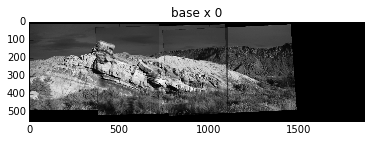

In [156]:
#run through each of the images starting randomly
#for x in range(10):
if 1:
    #imgs = [rgb2gray(pano_imgs[0]), rgb2gray(pano_imgs[1]), rgb2gray(pano_imgs[2])]
    #base_x = randint(0,len(imgs))
    imgs = [rgb2gray(pano_imgs[0]), rgb2gray(pano_imgs[1]), rgb2gray(pano_imgs[2])]
    base_x = 0
    base_img = imgs.pop(base_x)
    print("RUNNING BASE X", base_x)
    #initialize to greater than len of possible images so we go 
    # through at least once
    
    base_img, imgs = find_all_matches(base_img, imgs)

    # if there are still images left over, use these to 
    # start a new base image
        

    plt.figure()
    plt.title('base x %s' %base_x)
    plt.imshow(base_img)
    plt.show()
